In [64]:
import tushare as ts
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import talib
from keras.callbacks import TensorBoard
from sklearn.preprocessing import MinMaxScaler
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
ts.set_token('457a66c9299e50e9e0b2bf6c2f122bb24d560735f01b443158d1c85e') # 日线接口
pro = ts.pro_api()
# df = pro.daily(ts_code='000001.SH', start_date='20100701', end_date='20190923')
df = ts.pro_bar(ts_code='000300.SH', asset='I', start_date='20100701', end_date='20191201')
look_back=10
foresight=1


/Users/chaozhan/opt/anaconda3/envs/py375/lib/python3.7/site-packages/tushare/util/upass.py:28: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  return str(df.ix[0]['token'])


In [65]:
df['trade_date'] = pd.to_datetime(df['trade_date'])
df['trade_date'] = df['trade_date'].map(lambda x:x.strftime('%Y-%m-%d'))
# df.set_index('trade_date', inplace=True)
df=df.sort_values(by='trade_date')
df=df.reset_index(drop=True) #重置索引
print(df.shape)
#降序


(2291, 11)


In [66]:
df['RSI'] = talib.RSI(df['close'], timeperiod = 9)
df['WILLR']= talib.WILLR(df['high'], df['low'].values, df['close'].values, 7)
df1=df.dropna()
df1 = df1.drop(['trade_date','ts_code','pre_close','change','pct_chg','vol'],axis=1) #删除
print(df1.shape)

(2282, 7)


In [67]:

train_test_split = int(df1.shape[0]*0.8)
df1=df1.values
print(df1.shape)
# df1_close=df1[:,0]
# df1=np.delete(df1,0,axis=1)
scaler = MinMaxScaler(feature_range=(0, 1)) #不能使用一维的数据
# scaler1_close = MinMaxScaler(feature_range=(0, 1))
df1=scaler.fit_transform(df1)
# df1_close=scaler.fit_transform(df1_close)
# x_train=scaler.fit_transform(x_train)
# x_test=scaler.fit_transform(x_test)
# y_train=scaler.fit_transform(y_train)
# y_test==scaler.fit_transform(y_test)

(2282, 7)


In [68]:
x_pre_train=df1[:train_test_split,:]
x_pre_test=df1[train_test_split:,:]

In [69]:
def create_dataset(dataset, look_back, foresight):   
    X, Y = [], []
    for i in range(len(dataset)-look_back-foresight): 
        obs = dataset[i:(i+look_back),:] # Sequence of 7 stock prices as features forming an observation                                        
       # Append sequence
        X.append(obs)
       # Append stock price value occurring 4 time-steps into future
        Y.append(dataset[i + (look_back+foresight), 0]) 
    return np.array(X), np.array(Y)

In [70]:
x_train, y_train = create_dataset(x_pre_train, look_back, foresight)
x_test, y_test = create_dataset(x_pre_test, look_back, foresight)
print(x_train.shape,y_train.shape)
x_train

(1814, 10, 7) (1814,)


array([[[0.17345561, 0.17003703, 0.1734792 , ..., 0.03048232,
         0.73766734, 0.80629074],
        [0.15965304, 0.17288858, 0.17219947, ..., 0.02180795,
         0.59880627, 0.42449558],
        [0.16198224, 0.1567248 , 0.15407667, ..., 0.01532039,
         0.61180753, 0.44412674],
        ...,
        [0.21614805, 0.21446545, 0.21099503, ..., 0.05302491,
         0.81389754, 0.94037781],
        [0.22165163, 0.21787223, 0.21252004, ..., 0.0416337 ,
         0.82925249, 0.99622941],
        [0.21695864, 0.21938545, 0.21259822, ..., 0.03744871,
         0.76994785, 0.9274475 ]],

       [[0.15965304, 0.17288858, 0.17219947, ..., 0.02180795,
         0.59880627, 0.42449558],
        [0.16198224, 0.1567248 , 0.15407667, ..., 0.01532039,
         0.61180753, 0.44412674],
        [0.1822909 , 0.15523583, 0.17572378, ..., 0.04160916,
         0.70755083, 0.92972126],
        ...,
        [0.22165163, 0.21787223, 0.21252004, ..., 0.0416337 ,
         0.82925249, 0.99622941],
        [0.2

In [71]:
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense
from keras.layers import Dropout, Flatten
from keras.layers.embeddings import Embedding

from keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('训练历史')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['训练集','验证集'], loc='upper right')
    plt.show()
# print(x_train.shape)
# x_train=x_train.reshape(x_train.shape[0],-1)
# x_test=x_test.reshape(x_test.shape[0],-1)
# print(x_train.shape)

In [72]:
# model = Sequential()
# model.add(Flatten())
# model.add(Dense(units=128, activation='sigmoid'))
# model.add(Dropout(0.25))
# model.add(Dense(units=128, activation='sigmoid'))
# model.add(Dropout(0.25))
# model.add(Dense(units=1,  activation='sigmoid'))
# model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mse'])
# train_history = model.fit(x_train, y_train, validation_split=0.2, epochs=30, batch_size=100,  verbose=2)



In [73]:
# min_epoch=train_history.history['loss'].index(min(train_history.history['loss'])) #求最小的epoch在哪个位置
# print("最小的训练轮数是第",min_epoch,"\n最小的训练MSE为",min(train_history.history['loss']))
# print(model.summary())
# show_train_history(train_history,'loss','val_loss')
# scores = model.evaluate(x_test, y_test, verbose =1)
# print("测试集数据MSE为",scores[1])

In [74]:
batch_size = 100
epochs = 30

model1 = Sequential()
model1.add(LSTM(128,  input_shape=(look_back, 7), dropout=0.1, recurrent_dropout=0.1))
model1.add(Dense(units=256, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='mse', optimizer='adam', metrics = ['mse']) 
train_history1 = model1.fit(x_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size,  verbose=1)

Train on 1451 samples, validate on 363 samples
Epoch 1/30
1451/1451 [==============================] - 2s 1ms/step - loss: 0.0659 - mean_squared_error: 0.0659 - val_loss: 0.0447 - val_mean_squared_error: 0.0447
Epoch 2/30
1451/1451 [==============================] - 0s 196us/step - loss: 0.0210 - mean_squared_error: 0.0210 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 3/30
1451/1451 [==============================] - 0s 228us/step - loss: 0.0094 - mean_squared_error: 0.0094 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 4/30
1451/1451 [==============================] - 0s 225us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 5/30
1451/1451 [==============================] - 0s 220us/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 6.2228e-04 - val_mean_squared_error: 6.2228e-04
Epoch 6/30
1451/1451 [==============================] - 0s 208us/step - loss: 0.0036 - mean_squared_error: 0.0036 - v

最小的训练轮数是第 4 
最小的训练MSE为 0.0006222806167955569
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 128)               69632     
_________________________________________________________________
dense_7 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 102,913
Trainable params: 102,913
Non-trainable params: 0
_________________________________________________________________
None
446/446 [==============================] - 0s 81us/step
测试集数据MSE为 0.002658122734922598


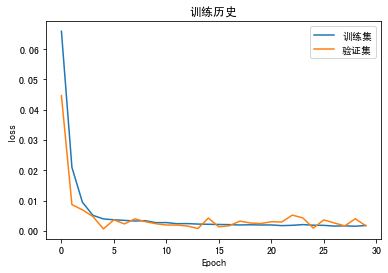

In [75]:
min_epoch=train_history1.history['val_loss'].index(min(train_history1.history['val_loss'])) #求最小的epoch在哪个位置
print("最小的训练轮数是第",min_epoch,"\n最小的训练MSE为",min(train_history1.history['val_loss']))
# min_epoch=np.where(np.array(train_history.history['val_loss'])==np.min(train_history.history['val_loss'],axis=0))#另外一种做法
# list(min_epoch)[0][0]
# print(model.summary())
# show_train_history(train_history,'loss','val_loss')

print(model1.summary())
show_train_history(train_history1,'loss','val_loss')

# scores = model.evaluate(x_test, y_test, verbose =2)
# scores
scores = model1.evaluate(x_test, y_test, verbose =1)
print("测试集数据MSE为",scores[1])


447/447 [==============================] - 0s 39us/step
测试集数据MSE [0.0033872869392852787, 0.0033872869392852787]


In [76]:
# test_predict=model.predict(x_test)
# print(test_predict.shape,test_predict)
test_predict=model1.predict(x_test,batch_size=batch_size,verbose=1)
print(test_predict.shape,type(test_predict),test_predict)


446/446 [==============================] - 0s 927us/step
(446, 1) <class 'numpy.ndarray'> [[0.68366295]
 [0.68324995]
 [0.6495201 ]
 [0.6082903 ]
 [0.5973037 ]
 [0.5861231 ]
 [0.585162  ]
 [0.58699214]
 [0.56357455]
 [0.54175645]
 [0.51894164]
 [0.49461672]
 [0.48115572]
 [0.48342592]
 [0.48539537]
 [0.5068438 ]
 [0.53113174]
 [0.5527841 ]
 [0.55210435]
 [0.5331495 ]
 [0.53056353]
 [0.50906295]
 [0.499214  ]
 [0.5166488 ]
 [0.5131181 ]
 [0.5352371 ]
 [0.5569643 ]
 [0.57205683]
 [0.5619856 ]
 [0.54812837]
 [0.5459938 ]
 [0.525699  ]
 [0.52166104]
 [0.52027845]
 [0.5168142 ]
 [0.5037429 ]
 [0.4913053 ]
 [0.47427544]
 [0.4766246 ]
 [0.4602345 ]
 [0.46638176]
 [0.47081953]
 [0.48417896]
 [0.47765234]
 [0.47377375]
 [0.46821395]
 [0.49322662]
 [0.50533384]
 [0.49396342]
 [0.47835433]
 [0.4582748 ]
 [0.43927497]
 [0.43837732]
 [0.44734225]
 [0.44169745]
 [0.43904817]
 [0.46838295]
 [0.47819716]
 [0.461154  ]
 [0.45217553]
 [0.4481103 ]
 [0.4544334 ]
 [0.450909  ]
 [0.47575253]
 [0.4919224 ]


In [77]:
# test_predict=test_predict[0:440]
x_pre_test=x_pre_test[look_back+foresight:,1:7]  #x_pre_test=x_pre_test[:-10,1:7] ?????
x_pre_test=np.concatenate([test_predict,x_pre_test], axis=1)
test_predict=scaler.inverse_transform(x_pre_test)
print(x_pre_test.shape)

(446, 7)


In [78]:
print(test_predict.shape,test_predict)

(446, 7) [[ 4.32034619e+03  4.38705770e+03  4.39590530e+03 ...  2.56176324e+08
   5.62935903e+01 -7.57693642e+01]
 [ 4.31899701e+03  4.28668340e+03  4.30851150e+03 ...  1.86650566e+08
   4.70743508e+01 -9.70141711e+01]
 [ 4.20880887e+03  4.23411010e+03  4.28785760e+03 ...  1.94401798e+08
   5.09691283e+01 -7.47158265e+01]
 ...
 [ 3.62862901e+03  3.88342900e+03  3.88997830e+03 ...  1.07238822e+08
   4.34384728e+01 -6.29057417e+01]
 [ 3.65358570e+03  3.87790120e+03  3.88769030e+03 ...  8.70817889e+07
   4.06476306e+01 -7.37526886e+01]
 [ 3.63349739e+03  3.85718830e+03  3.86165840e+03 ...  1.16200557e+08
   3.43725712e+01 -7.90881278e+01]]


In [79]:
test_predict_1line=test_predict[:,0]
test_predict_1line.shape
df.loc[df.shape[0]-test_predict_1line.shape[0]:,'close'].values

array([4302.0181, 4256.1021, 4275.8986, 4245.8978, 4271.2326, 4274.1464,
       4148.8856, 4050.4972, 4012.0472, 3840.6527, 3890.1046, 3935.6324,
       3966.9614, 4052.7332, 4071.0889, 4118.4186, 4058.9806, 4023.6415,
       4049.0863, 4016.461 , 4018.097 , 4066.5647, 4036.6536, 4077.6001,
       4108.8652, 4127.6662, 4091.2533, 4073.3447, 4096.1627, 4056.4226,
       4074.2479, 4077.7041, 4061.0502, 4020.349 , 3904.9355, 3879.893 ,
       3913.2689, 3842.7155, 3894.0498, 3898.4977, 3886.9189, 3862.4796,
       3854.8625, 3852.9292, 3927.1729, 3938.3434, 3898.6354, 3871.1443,
       3808.863 , 3748.6412, 3766.282 , 3811.843 , 3760.8543, 3766.3257,
       3843.4886, 3828.7015, 3755.4941, 3756.8765, 3763.6461, 3793.0001,
       3774.5981, 3834.1877, 3878.6767, 3871.6152, 3893.0565, 3872.8383,
       3909.2933, 3924.0975, 3892.8442, 3864.0507, 3903.0637, 3921.2421,
       3906.2081, 3854.5825, 3827.217 , 3816.498 , 3833.2599, 3804.0093,
       3723.3724, 3802.3759, 3770.5891, 3807.5781, 

In [80]:
backtest = pd.DataFrame(test_predict_1line,columns=['close_predict'])
backtest['close'] = df.loc[df.shape[0]-test_predict_1line.shape[0]:,'close'].values  #同一天
backtest['trade_date'] = df.loc[df.shape[0]-test_predict_1line.shape[0]:,'trade_date'].values
# backtest = pd.DataFrame(test_predict_1line , df.loc[df.shape[0]-test_predict_1line.shape[0]:,'close'],columns=['close_predict','close'])

In [81]:
df[df['close']==backtest['close'][0]].trade_date

1845    2018-01-29
Name: trade_date, dtype: object

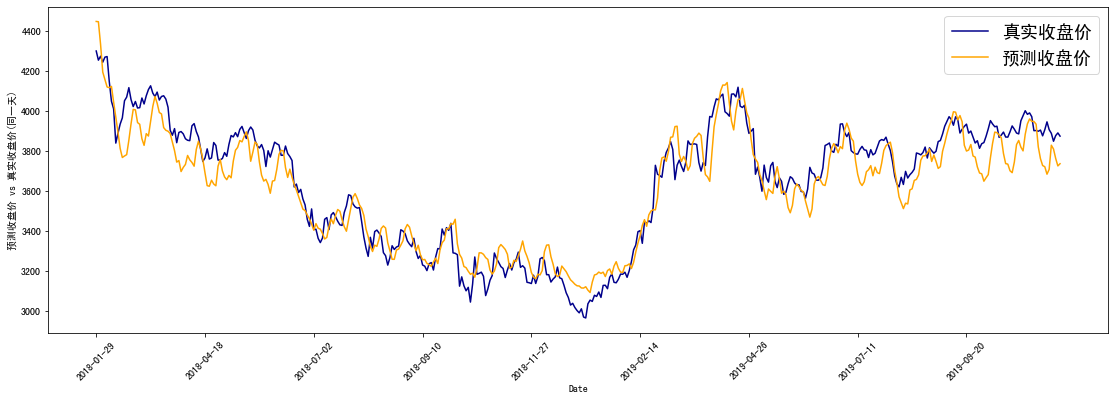

In [97]:
plt.figure(figsize = (19,6))
plt.plot(range(backtest.shape[0]),backtest['close'],color='darkblue',label='真实收盘价')
plt.plot(range(backtest.shape[0]),backtest['close_predict']*1.03,color='orange',label='预测收盘价')
plt.xticks(range(0,backtest.shape[0],50),backtest['trade_date'][::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('预测收盘价 vs 真实收盘价(同一天)')
plt.legend(fontsize=18)
plt.show()

In [92]:
backtest[str('close_'+str(foresight)+'_day_before')]=backtest['close'].shift(-foresight)
backtest.set_index('trade_date', drop= True, inplace = False)
# print(backtest.loc[0,'trade_date'])
# df1.loc['2017-02-03':'2017-02-06']
backtest.dropna(inplace=True)
# print(backtest)


In [93]:
backtest['buy']=np.where(backtest['close_predict']>backtest['close_'+str(foresight)+'_day_before'],1,0)

'close1_day_before'